In [12]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import admix
from tqdm import tqdm
import string

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [13]:
def estimate_hsq(dict_est, scale_factor=1):
    """
    Estimate the ratio with delta method, est[0] (var_g) / [est[0] (var_g) + est[1] (var_e)]
    est: (2, ) numpy array
    est_var (2, 2) variance-covariance matrix
    """
    assert len(dict_est["est"]) == 2
    assert np.all(dict_est["est"].Source.values == ["V(G)", "V(e)"])
    est = dict_est["est"].Variance.values
    est_var = dict_est["varcov"].values

    ## method 1
    x, y = est[0], est[1]
    hsq = (x * scale_factor) / (x * scale_factor + y)

    # grad = [y / (x + y)^2, - x / (x + y)^2]
    grad = np.array(
        [
            scale_factor * y / ((scale_factor * x + y) ** 2),
            -scale_factor * x / ((scale_factor * x + y) ** 2),
        ]
    )

    ## method2
    #     x, y = est[0] * scale_factor, est[1]

    #     est_var[0, :] *= scale_factor
    #     est_var[:, 0] *= scale_factor

    #     hsq = x / (x + y)

    #     # grad = [y / (x + y)^2, - x / (x + y)^2]

    #     grad = np.array([y / ((x + y) ** 2), -x / ((x + y) ** 2)])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return hsq, quad_form(grad, est_var)

# Store SNP weights

In [14]:
GRM_DIR = "/u/scratch/k/kangchen/admix-grm"
GENO_DIR = "/u/home/k/kangchen/PAGE-QC/01-dataset/out/aframr"

In [15]:
dict_df_weight = dict()

for snpset in ["hm3", "imputed"]:
    df_weight = pd.read_csv(
        os.path.join(GRM_DIR, f"{snpset}.mafukb.005.merged.weight.tsv"),
        sep="\t",
        index_col=0,
    )

    df_freq = (
        pd.concat(
            [
                pd.read_csv(
                    f"{GENO_DIR}/{snpset}/chr{chrom}.freq",
                    delim_whitespace=True,
                )
                for chrom in range(1, 23)
            ]
        )
        .reset_index(drop=True)
        .set_index("ID")
    )

    df_weight["PRIOR_VAR"] /= df_weight["PRIOR_VAR"].sum()
    df_weight["FREQ"] = df_freq["ALT_FREQS"].reindex(df_weight.index)
    df_weight["FREQ_VAR"] = 2 * df_weight["FREQ"] * (1 - df_weight["FREQ"])
    dict_df_weight[snpset] = df_weight

In [16]:
dict_scale_factor

{'hm3': 0.3151273932389744, 'imputed': 0.24884752564563367}

In [17]:
dict_scale_factor = {
    k: np.sum(df["PRIOR_VAR"] * df["FREQ_VAR"]) for k, df in dict_df_weight.items()
}

# Read heritability estimation

In [18]:
pheno_prefix_list = [f.split("/")[-1] for f in glob.glob("out/gcta-estimate/*")]
# pheno_prefix_list = [p for p in pheno_prefix_list if "pcausal-0.001" in p]
grm_prefix_list = ["hm3.mafukb.005", "imputed.mafukb.005"]

In [19]:
def parse_prefix(pheno_prefix, grm_prefix):
    split = pheno_prefix.split("-")
    hsq, pcausal, cor = float(split[1]), float(split[3]), float(split[5])
    snpset = grm_prefix.split(".")[0]
    return hsq, pcausal, cor, snpset

In [22]:
df_raw = []
for pheno_prefix in pheno_prefix_list:
    for grm_prefix in grm_prefix_list:

        hsq, pcausal, cor, snpset = parse_prefix(pheno_prefix, grm_prefix)

        f_dir = os.path.join(f"out/gcta-estimate/{pheno_prefix}", grm_prefix)

        for sim_i in range(100):
            try:

                dict_est = admix.tools.gcta.read_reml(
                    os.path.join(f_dir, f"sim_{sim_i}.rho100")
                )
                est, est_var = estimate_hsq(
                    dict_est, scale_factor=dict_scale_factor[snpset]
                )

                #                 var_est = admix.tools.gcta.read_reml(
                #                     os.path.join(f_dir, f"sim_{sim_i}.rho100")
                #                 )["est"]["Variance"].values.tolist()
                df_raw.append(
                    [hsq, pcausal, cor, snpset, sim_i] + [est, np.sqrt(est_var)]
                )
            except ValueError:
                print(f_dir, sim_i)


df_raw = pd.DataFrame(
    df_raw,
    columns=[
        "hsq",
        "pcausal",
        "cor",
        "snpset",
        "sim_i",
        "estimated_hsq",
        "estimated_se",
    ],
)
# df_raw["scaled_var_g"] = df_raw.apply(
#     lambda x: x["var_g"] * dict_scale_factor[x.snpset], axis=1
# )
# df_raw["estimated_hsq"] = df_raw["scaled_var_g"] / (
#     df_raw["scaled_var_g"] + df_raw["var_e"]
# )

out/gcta-estimate/hsq-0.1-pcausal-0.0001-cor-0.9-hermodel-mafukb/imputed.mafukb.005 77
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-0.9-hermodel-mafukb/hm3.mafukb.005 78
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-0.95-hermodel-mafukb/hm3.mafukb.005 95
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-mafukb/imputed.mafukb.005 17
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-mafukb/imputed.mafukb.005 55
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-mafukb/imputed.mafukb.005 63
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-mafukb/imputed.mafukb.005 90


In [32]:
df_raw['pcausal']

,hsq,pcausal,cor,snpset,sim_i,estimated_hsq,estimated_se
0,0.10,0.001,0.9,hm3,0,0.115882,0.020855
1,0.10,0.001,0.9,hm3,1,0.078527,0.019483
2,0.10,0.001,0.9,hm3,2,0.079606,0.017519
3,0.10,0.001,0.9,hm3,3,0.152503,0.021879
4,0.10,0.001,0.9,hm3,4,0.111445,0.021230
...,...,...,...,...,...,...,...
4788,0.25,0.010,1.0,imputed,95,0.229610,0.023232
4789,0.25,0.010,1.0,imputed,96,0.229086,0.022916
4790,0.25,0.010,1.0,imputed,97,0.219988,0.023096
4791,0.25,0.010,1.0,imputed,98,0.284324,0.023352


In [34]:
empirical_std = (
    df_raw.query("pcausal==0.001")
    .groupby(["snpset", "hsq", "cor", "pcausal"])
    .std()["estimated_hsq"]
)
avg_se = (
    df_raw.query("pcausal==0.001")
    .groupby(["snpset", "hsq", "cor", "pcausal"])
    .mean()["estimated_se"]
)

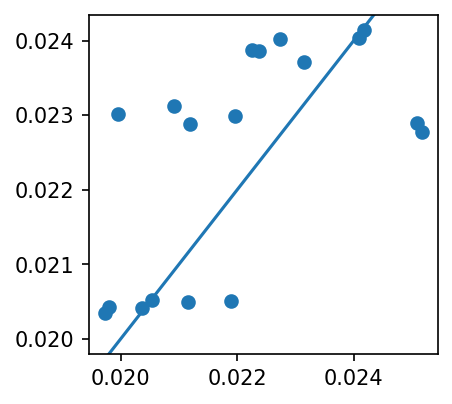

In [38]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
plt.scatter(empirical_std, avg_se)
ax.axline((0.02, 0.02), slope=1)

In [24]:
df_mean = df_raw.groupby(["snpset", "hsq", "cor", "pcausal"]).apply(
    lambda x: pd.Series({"mean": np.mean(x["estimated_hsq"])})
)
df_sem = df_raw.groupby(["snpset", "hsq", "cor", "pcausal"]).apply(
    lambda x: pd.Series({"sem": np.std(x["estimated_hsq"]) / np.sqrt(len(x))})
)
df_plot = pd.merge(df_mean, df_sem, left_index=True, right_index=True).reset_index()

In [25]:
df_plot

,snpset,hsq,cor,pcausal,mean,sem
0,hm3,0.10,0.90,0.00010,0.097556,0.002007
1,hm3,0.10,0.90,0.00100,0.104025,0.002179
2,hm3,0.10,0.95,0.00010,0.099700,0.001894
3,hm3,0.10,0.95,0.00100,0.096188,0.002026
4,hm3,0.10,1.00,0.00010,0.092118,0.002261
5,hm3,0.10,1.00,0.00100,0.091806,0.002044
6,hm3,0.25,0.90,0.00001,0.240332,0.003495
7,hm3,0.25,0.90,0.00010,0.243949,0.002193
8,hm3,0.25,0.90,0.00100,0.243499,0.002505
9,hm3,0.25,0.90,0.01000,0.242244,0.002300


# Supp. Table

In [41]:
## fixed pcausal and vary h2
df_display = df_plot[df_plot.pcausal == 0.001]

df_display = (
    df_display.drop(columns=["pcausal"])[["hsq", "cor", "snpset", "mean", "sem"]]
    .sort_values(["hsq", "cor", "snpset"])
    .rename(
        columns={
            "hsq": "$h_g^2$",
            "cor": "$r_g$",
            "snpset": "SNP set",
            "mean": "Mean",
            "sem": "SEM",
        }
    )
)

for col in ["Mean", "SEM"]:
    df_display[col] = df_display[col].apply(lambda x: f"{x:.3g}")

display(df_display)
print(df_display.to_latex(escape=False, index=False))

,$h_g^2$,$r_g$,SNP set,Mean,SEM
1,0.10,0.90,hm3,0.104,0.00218
25,0.10,0.90,imputed,0.11,0.0021
3,0.10,0.95,hm3,0.0962,0.00203
27,0.10,0.95,imputed,0.101,0.00196
5,0.10,1.00,hm3,0.0918,0.00204
29,0.10,1.00,imputed,0.0972,0.00197
8,0.25,0.90,hm3,0.243,0.0025
32,0.25,0.90,imputed,0.259,0.0025
12,0.25,0.95,hm3,0.239,0.00211
36,0.25,0.95,imputed,0.255,0.00219


\begin{tabular}{rrlll}
\toprule
 $h_g^2$ &  $r_g$ & SNP set &   Mean &     SEM \\
\midrule
    0.10 &   0.90 &     hm3 &  0.104 & 0.00218 \\
    0.10 &   0.90 & imputed &   0.11 &  0.0021 \\
    0.10 &   0.95 &     hm3 & 0.0962 & 0.00203 \\
    0.10 &   0.95 & imputed &  0.101 & 0.00196 \\
    0.10 &   1.00 &     hm3 & 0.0918 & 0.00204 \\
    0.10 &   1.00 & imputed & 0.0972 & 0.00197 \\
    0.25 &   0.90 &     hm3 &  0.243 &  0.0025 \\
    0.25 &   0.90 & imputed &  0.259 &  0.0025 \\
    0.25 &   0.95 &     hm3 &  0.239 & 0.00211 \\
    0.25 &   0.95 & imputed &  0.255 & 0.00219 \\
    0.25 &   1.00 &     hm3 &  0.229 & 0.00199 \\
    0.25 &   1.00 & imputed &  0.247 & 0.00208 \\
    0.50 &   0.90 &     hm3 &  0.468 &  0.0023 \\
    0.50 &   0.90 & imputed &  0.502 & 0.00223 \\
    0.50 &   0.95 &     hm3 &  0.462 & 0.00221 \\
    0.50 &   0.95 & imputed &  0.498 & 0.00226 \\
    0.50 &   1.00 &     hm3 &   0.46 &  0.0024 \\
    0.50 &   1.00 & imputed &  0.498 &  0.0024 \\
\bottomru

In [40]:
## fixed pcausal and vary h2
df_display = df_plot[df_plot.hsq == 0.25]

df_display = (
    df_display.drop(columns=["hsq"])[["pcausal", "cor", "snpset", "mean", "sem"]]
    .sort_values(["pcausal", "cor", "snpset"])
    .rename(
        columns={
            "pcausal": "$p_\text{causal}$",
            "hsq": "$h_g^2$",
            "cor": "$r_g$",
            "snpset": "SNP set",
            "mean": "Mean",
            "sem": "SEM",
        }
    )
)
df_display["$p_\text{causal}$"] = df_display["$p_\text{causal}$"].apply(
    lambda x: f"{x * 100:.1g}\%"
)

for col in ["Mean", "SEM"]:
    df_display[col] = df_display[col].apply(lambda x: f"{x:.3g}")

display(df_display)
print(df_display.to_latex(escape=False, index=False))

,$p_\text{causal}$,$r_g$,SNP set,Mean,SEM
6,0.001\%,0.90,hm3,0.24,0.0035
30,0.001\%,0.90,imputed,0.256,0.00377
10,0.001\%,0.95,hm3,0.234,0.00374
34,0.001\%,0.95,imputed,0.252,0.00446
14,0.001\%,1.00,hm3,0.235,0.00386
38,0.001\%,1.00,imputed,0.252,0.00448
7,0.01\%,0.90,hm3,0.244,0.00219
31,0.01\%,0.90,imputed,0.261,0.00229
11,0.01\%,0.95,hm3,0.239,0.00251
35,0.01\%,0.95,imputed,0.256,0.00252


\begin{tabular}{lrlll}
\toprule
$p_\text{causal}$ &  $r_g$ & SNP set &  Mean &     SEM \\
\midrule
          0.001\% &   0.90 &     hm3 &  0.24 &  0.0035 \\
          0.001\% &   0.90 & imputed & 0.256 & 0.00377 \\
          0.001\% &   0.95 &     hm3 & 0.234 & 0.00374 \\
          0.001\% &   0.95 & imputed & 0.252 & 0.00446 \\
          0.001\% &   1.00 &     hm3 & 0.235 & 0.00386 \\
          0.001\% &   1.00 & imputed & 0.252 & 0.00448 \\
           0.01\% &   0.90 &     hm3 & 0.244 & 0.00219 \\
           0.01\% &   0.90 & imputed & 0.261 & 0.00229 \\
           0.01\% &   0.95 &     hm3 & 0.239 & 0.00251 \\
           0.01\% &   0.95 & imputed & 0.256 & 0.00252 \\
           0.01\% &   1.00 &     hm3 & 0.231 & 0.00246 \\
           0.01\% &   1.00 & imputed & 0.249 & 0.00259 \\
            0.1\% &   0.90 &     hm3 & 0.243 &  0.0025 \\
            0.1\% &   0.90 & imputed & 0.259 &  0.0025 \\
            0.1\% &   0.95 &     hm3 & 0.239 & 0.00211 \\
            0.1\% &   0.95 & im

In [24]:
assert False

AssertionError: 

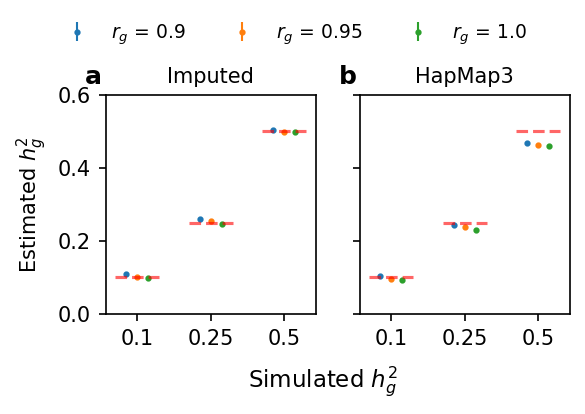

In [31]:
dict_title = {"hm3": "HapMap3", "imputed": "Imputed"}

fig, axes = plt.subplots(figsize=(4.0, 2.2), dpi=150, ncols=2, sharey=True)
for i_snpset, snpset in enumerate(["imputed", "hm3"]):

    # error bars
    for i_cor, cor in enumerate([0.9, 0.95, 1.0]):
        df_tmp = df_plot[(df_plot.snpset == snpset) & (df_plot.cor == cor)]

        axes[i_snpset].errorbar(
            x=np.arange(len(df_tmp)) + (i_cor - 1) * 0.15,
            y=df_tmp["mean"],
            yerr=df_tmp["sem"] * 2,
            fmt=".",
            ms=4,
            mew=1,
            lw=1,
            label=f"$r_g$ = {cor}",
        )

    # box plots
    # x-axis
    axes[i_snpset].set_xticks([0, 1, 2])
    axes[i_snpset].set_xticklabels([0.1, 0.25, 0.5])

    # y-axis
    axes[i_snpset].set_ylim(0, 0.6)
    if i_snpset == 0:
        axes[i_snpset].set_ylabel("Estimated $h_g^2$")

    # title
    axes[i_snpset].set_title(dict_title[snpset], fontsize=10)
    for i_hsq, hsq in enumerate([0.1, 0.25, 0.5]):
        axes[i_snpset].hlines(
            y=hsq,
            xmin=i_hsq - 0.3,
            xmax=i_hsq + 0.3,
            color="red",
            ls="--",
            alpha=0.6,
            zorder=10,
        )
    # annotation
    axes[i_snpset].text(
        -0.1,
        1.05,
        string.ascii_lowercase[i_snpset],
        transform=axes[i_snpset].transAxes,
        size=12,
        weight="bold",
    )

fig.text(
    0.55,
    -0.05,
    "Simulated $h_g^2$",
    fontsize=11,
    ha="center",
)

handles, labels = axes[0].get_legend_handles_labels()
# handles = ph + handles
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.tight_layout()
fig.savefig("results/estimate-h2g.pdf", bbox_inches="tight")